In [151]:
import tqdm
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
# Make plots inline
%matplotlib inline
import urllib.request
import os
from scipy.io import loadmat
from math import floor


In [152]:
X = torch.linspace(-2,2,10000).reshape(-1,1)
y = torch.sin(X)

train_n = int(floor(1 * len(X)))
train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

In [153]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [154]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

inducing_points = torch.linspace(-2,2,5).reshape(-1,1)
model = GPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [155]:
num_epochs = 200


model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))


epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch)
#         print(output.mean.size())
        y_batch=y_batch.reshape(-1,)
#         print(y_batch.size())
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/10 [00:00<?, ?it/s]

In [156]:
# model.eval()
# likelihood.eval()
# means = torch.tensor([0.])
# with torch.no_grad():
#     for x_batch, y_batch in test_loader:
#         preds = model(x_batch)
#         means = torch.cat([means, preds.mean])
# means = means[1:]
# model=model.cpu()

In [205]:
X = torch.linspace(-4,4,10000).reshape(-1,1)
X=X.cuda()
with torch.no_grad():
    mu_svgp=model(X).mean
    sigma_svgp=model(X).variance
    std_svgp=torch.sqrt(sigma_svgp)
    x_inducing=model.variational_strategy.inducing_points
    y_inducing=model(x_inducing).mean
    kernel=model.covar_module
    k_star=kernel(X,x_inducing)
    K=kernel(x_inducing,x_inducing)
    Noise=torch.tensor(torch.eye(K.shape[0]).cuda()*likelihood.noise)
    Jitter=torch.tensor(torch.eye(K.shape[0]).cuda()*gpytorch.settings.cholesky_jitter.value())
    K=K+Jitter
    alpha=K.inv_matmul(y_inducing)
    mu_exact= kernel(X,x_inducing).matmul(alpha)
    K=K+Noise
    sigma_exact=likelihood.noise+torch.diag(kernel(X,X).evaluate()-kernel(X,x_inducing).evaluate() @ (torch.linalg.inv(K.evaluate()) @(kernel(x_inducing,X).evaluate())))
    std_exact=torch.sqrt(sigma_exact)

<ipython-input-205-ded2bda45eff>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Noise=torch.tensor(torch.eye(K.shape[0]).cuda()*likelihood.noise)
<ipython-input-205-ded2bda45eff>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Jitter=torch.tensor(torch.eye(K.shape[0]).cuda()*gpytorch.settings.cholesky_jitter.value())


Text(0.5, 1.0, 'Prediction with svgp model')

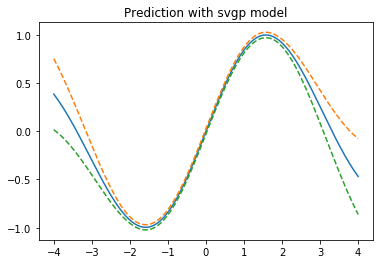

In [206]:
plt.plot(X.cpu(),mu_svgp.cpu())
plt.plot(X.cpu(), mu_svgp.cpu()+std_svgp.cpu(), '--')
plt.plot(X.cpu(), mu_svgp.cpu()-std_svgp.cpu(), '--')
plt.title('Prediction with svgp model')

Text(0.5, 1.0, 'Prediction with exact model')

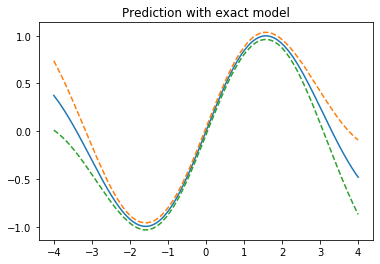

In [207]:
plt.plot(X.cpu(),mu_exact.cpu())
plt.plot(X.cpu(), mu_exact.cpu()+std_exact.cpu(), '--')
plt.plot(X.cpu(), mu_exact.cpu()-std_exact.cpu(), '--')
plt.title('Prediction with exact model')

In [208]:
torch.mean(std_svgp.cpu()-std_exact.cpu())

tensor(-0.0038)

In [209]:
torch.mean(mu_exact-mu_svgp)

tensor(-0.0017, device='cuda:0')